<a href="https://colab.research.google.com/github/pwilliamspeniel/Deep-Hybrid-Model/blob/main/training_stage_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Reconstruction

## STAGE 1

Training images shape: (1000, 256, 256, 3)
Validation images shape: (300, 256, 256, 3)
Test images shape: (200, 256, 256, 3)
Images normalized
Training demographics shape: (1000, 10)
Validation demographics shape: (300, 10)
Test demographics shape: (200, 10)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d[0][0]']              
 D)                              

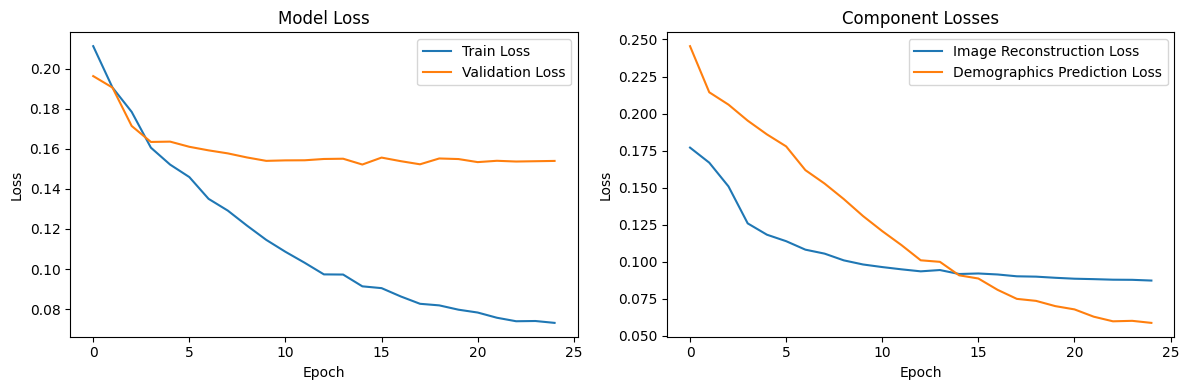

7/7 [==============================] - 23s 3s/step


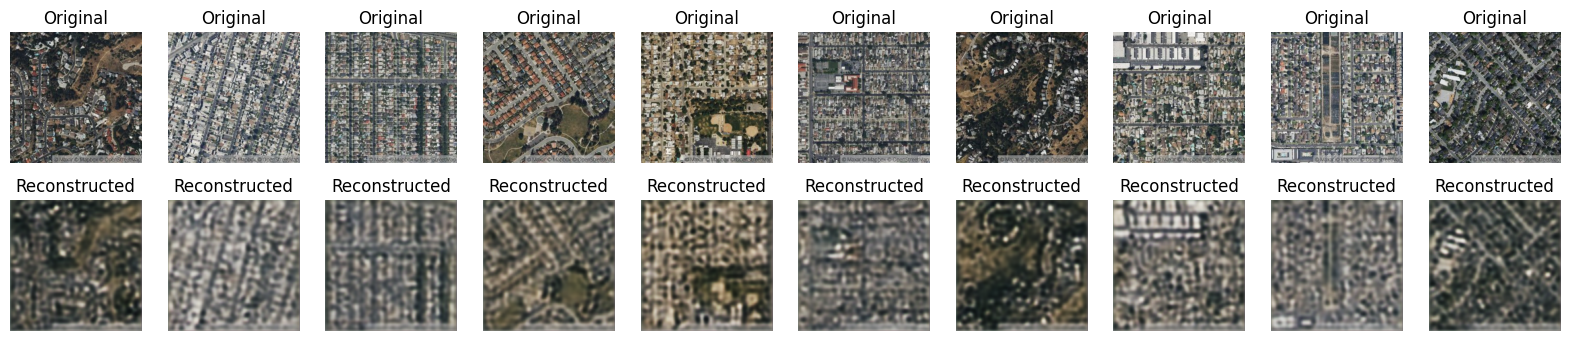

Sample predicted demographics:
[[0.32979542 0.22648154 0.2970357  0.15931125 0.33540127 0.21353318
  0.07592294 0.35918143 0.301184   0.2797853 ]
 [0.26736557 0.19550233 0.3456247  0.1452767  0.1773696  0.30490205
  0.03905927 0.24650064 0.35996577 0.20749502]
 [0.33739126 0.22043616 0.2681674  0.0825975  0.17084575 0.24844988
  0.04822461 0.18133427 0.27901924 0.10776851]
 [0.35959244 0.2209927  0.44233903 0.19169329 0.32053638 0.29213864
  0.05036772 0.28409216 0.447492   0.2495164 ]
 [0.361562   0.22154893 0.30378264 0.1727463  0.26416376 0.27926177
  0.02143227 0.352097   0.3334777  0.20995782]]

Actual demographics:
[[0.34141518 0.25222293 0.42036555 0.13119701 0.24523895 0.31892201
  0.01771313 0.3691628  0.4028792  0.25455482]
 [0.35070071 0.53824707 0.46809682 0.1203765  0.27154752 0.47930809
  0.10981181 0.23748655 0.61783186 0.19951523]
 [0.17651105 0.10197057 0.3180827  0.12453894 0.07751774 0.29648197
  0.21412033 0.18830357 0.28726595 0.15294225]
 [0.25793139 0.12622308 0.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess images
def load_images_from_folder(folder, filenames, target_size=(256, 256)):
    images = []
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Load CSV files
train_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/train_data.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/val_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/test_data.csv')

# Limit to the first 1000, 300, and 200 filenames respectively
train_images_filenames = train_df['filename'].tolist()[:1000]
val_images_filenames = val_df['filename'].tolist()[:300]
test_images_filenames = test_df['filename'].tolist()[:200]

# Load images
image_dir = '/content/drive/MyDrive/Autoencoders/data_dir/images'
x_train = load_images_from_folder(image_dir, train_images_filenames)
x_val = load_images_from_folder(image_dir, val_images_filenames)
x_test = load_images_from_folder(image_dir, test_images_filenames)

print(f"Training images shape: {x_train.shape}")
print(f"Validation images shape: {x_val.shape}")
print(f"Test images shape: {x_test.shape}")

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("Images normalized")

# Demographic columns
demographic_columns = ['tot_population', 'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs',
                       'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone', 'pct_col_degree',
                       'avg_tt_to_work', 'inc_per_capita']

# Extract demographics data
train_demographics = train_df[demographic_columns][:1000].values
val_demographics = val_df[demographic_columns][:300].values
test_demographics = test_df[demographic_columns][:200].values

print(f"Training demographics shape: {train_demographics.shape}")
print(f"Validation demographics shape: {val_demographics.shape}")
print(f"Test demographics shape: {test_demographics.shape}")

# Normalize demographic data
scaler = MinMaxScaler()
train_demographics = scaler.fit_transform(train_demographics)
val_demographics = scaler.transform(val_demographics)
test_demographics = scaler.transform(test_demographics)

def create_supervised_autoencoder(image_shape=(256, 256, 3), demographic_shape=10, lambda_value=0.5, alpha_sup=2):
    input_img = Input(shape=image_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Latent space
    latent = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(latent)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_image')(x)

    # Sociodemographic Predictor
    x = Flatten()(latent)
    demographics_output = Dense(demographic_shape, activation='linear', name='demographics_output')(x)

    # Custom loss functions
    def reconstruction_loss(y_true, y_pred):
        return K.mean(K.abs(y_true - y_pred), axis=[1,2,3])

    def demographic_loss(y_true, y_pred):
        return alpha_sup * K.mean(K.abs(y_true - y_pred), axis=-1)

    # Model
    autoencoder = Model(inputs=input_img, outputs=[decoded, demographics_output])
    autoencoder.compile(optimizer=Adam(learning_rate=1e-4),
                        loss=[reconstruction_loss, demographic_loss],
                        loss_weights=[(1 - lambda_value), lambda_value])

    return autoencoder

# Create and compile the model
lambda_value = 0.5
alpha_sup = 2
model = create_supervised_autoencoder(image_shape=(256, 256, 3),
                                      demographic_shape=len(demographic_columns),
                                      lambda_value=lambda_value,
                                      alpha_sup=alpha_sup)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    x_train,
    [x_train, train_demographics],
    validation_data=(x_val, [x_val, val_demographics]),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/Autoencoders/data_dir/best_model_new.keras',
                        monitor='val_loss', save_best_only=True, mode='min'),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ]
)

# Save the final model
model.save('/content/drive/MyDrive/Autoencoders/data_dir/final_model_new.keras')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['decoded_image_loss'], label='Image Reconstruction Loss')
plt.plot(history.history['demographics_output_loss'], label='Demographics Prediction Loss')
plt.title('Component Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
reconstructed_images, predicted_demographics = model.predict(x_test)

# Display some original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()

# Print some predicted demographics
print("Sample predicted demographics:")
print(predicted_demographics[:5])
print("\nActual demographics:")
print(test_demographics[:5])

## STAGE 2

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Load CSV files
train_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/train_data.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/val_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Autoencoders/data_dir/test_data.csv')

# Limit to the first 1000, 300, and 200 filenames respectively
train_images_filenames = train_df['filename'].tolist()[:1000]
val_images_filenames = val_df['filename'].tolist()[:300]
test_images_filenames = test_df['filename'].tolist()[:200]

# Load images
def load_images_from_folder(folder, filenames, target_size=(256, 256)):
    images = []
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

image_dir = '/content/drive/MyDrive/Autoencoders/data_dir/images'
x_train = load_images_from_folder(image_dir, train_images_filenames)
x_val = load_images_from_folder(image_dir, val_images_filenames)
x_test = load_images_from_folder(image_dir, test_images_filenames)

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Demographic columns
demographic_columns = ['tot_population', 'pct25_34yrs', 'pct35_50yrs', 'pctover65yrs',
                       'pctwhite_alone', 'pct_nonwhite', 'pctblack_alone', 'pct_col_degree',
                       'avg_tt_to_work', 'inc_per_capita']

# Extract demographics data
train_demographics = train_df[demographic_columns][:1000].values
val_demographics = val_df[demographic_columns][:300].values
test_demographics = test_df[demographic_columns][:200].values

# Normalize demographic data
scaler = MinMaxScaler()
train_demographics = scaler.fit_transform(train_demographics)
val_demographics = scaler.transform(val_demographics)
test_demographics = scaler.transform(test_demographics)

# Load the final autoencoder model
autoencoder = load_model('/content/drive/MyDrive/Autoencoders/data_dir/final_model_new.keras', compile=False)

# Extract the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten').output)

# Extract features using the encoder
train_features = encoder.predict(x_train)
val_features = encoder.predict(x_val)
test_features = encoder.predict(x_test)

print(f"Training features shape: {train_features.shape}")
print(f"Validation features shape: {val_features.shape}")
print(f"Test features shape: {test_features.shape}")

# Columns for mode choice proportions
mode_choice_columns = ['pct_others', 'pct_public_transit', 'pct_active']

# Extract mode choice proportions
train_mode_choices = train_df[mode_choice_columns][:1000].values
val_mode_choices = val_df[mode_choice_columns][:300].values
test_mode_choices = test_df[mode_choice_columns][:200].values

print(f"Training mode choices shape: {train_mode_choices.shape}")
print(f"Validation mode choices shape: {val_mode_choices.shape}")
print(f"Test mode choices shape: {test_mode_choices.shape}")

# Combine features and mode choice proportions
train_features_combined = np.concatenate((train_features, train_demographics), axis=1)
val_features_combined = np.concatenate((val_features, val_demographics), axis=1)
test_features_combined = np.concatenate((test_features, test_demographics), axis=1)

print(f"Combined training features shape: {train_features_combined.shape}")
print(f"Combined validation features shape: {val_features_combined.shape}")
print(f"Combined test features shape: {test_features_combined.shape}")


7/7 [==============================] - 0s 16ms/step
Training features shape: (1000, 131072)
Validation features shape: (300, 131072)
Test features shape: (200, 131072)
Training mode choices shape: (1000, 3)
Validation mode choices shape: (300, 3)
Test mode choices shape: (200, 3)
Combined training features shape: (1000, 131082)
Combined validation features shape: (300, 131082)
Combined test features shape: (200, 131082)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 131082)]          0         
                                                                 
 dense_5 (Dense)             (None, 512)               67114496  
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 67287171 (256.68 MB)
Trainable params: 672871

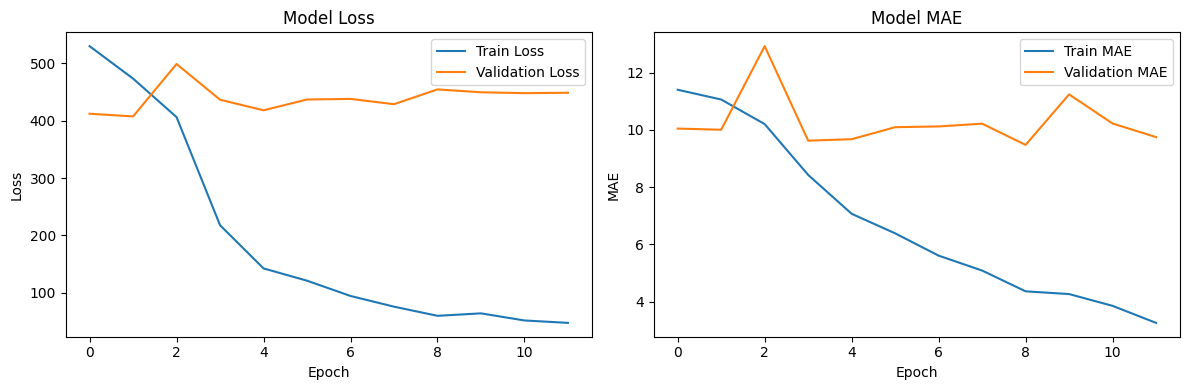

7/7 [==============================] - 0s 12ms/step - loss: 864.8795 - mae: 12.2724
Test Loss: 864.8795166015625
Test MAE: 12.272414207458496
7/7 [==============================] - 0s 8ms/step
Sample predicted mode choices:
[[ 2.1444335   4.0330253  11.730189  ]
 [ 3.8516426  32.080334    7.002587  ]
 [ 0.15360138  6.0347075   4.3691063 ]
 [ 0.7486024   5.309647    4.4907475 ]
 [ 2.7816312   4.767109    1.808154  ]]

Actual mode choices:
[[ 6.57084189 21.18327318  3.17983747]
 [ 9.0907462  93.45350046  0.        ]
 [ 1.01010101 31.9352465   2.35690236]
 [ 0.789177    4.68611458  0.        ]
 [ 2.15264188 32.95066914  0.        ]]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Assuming other necessary imports and data loading/preprocessing steps are already done

# Define the regression model
def build_regression_model(input_shape, output_shape):
    inputs = Input(shape=(input_shape,))
    x = Dense(512, activation='relu')(inputs)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(output_shape, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model

# Input shape is the number of combined features
input_shape = train_features_combined.shape[1]
output_shape = train_mode_choices.shape[1]

# Build and compile the regression model
regression_model = build_regression_model(input_shape, output_shape)

# Print model summary
regression_model.summary()

# Train the model
history = regression_model.fit(
    train_features_combined, train_mode_choices,
    validation_data=(val_features_combined, val_mode_choices),
    epochs=50,
    batch_size=32,
    shuffle=True,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/Autoencoders/data_dir/best_regression_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ]
)

# Save the final regression model
regression_model.save('/content/drive/MyDrive/Autoencoders/data_dir/final_regression_model.keras')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_mae = regression_model.evaluate(test_features_combined, test_mode_choices)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on the test set
predicted_mode_choices = regression_model.predict(test_features_combined)

# Print some sample predictions
print("Sample predicted mode choices:")
print(predicted_mode_choices[:5])
print("\nActual mode choices:")
print(test_mode_choices[:5])
